<a href="https://colab.research.google.com/github/alex-jk/painting-lora-finetune/blob/main/paintings_lora_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/alex-jk/painting-lora-finetune/main/data/paintings.zip -O paintings.zip
!unzip -o paintings.zip -d paintings/

--2025-04-08 02:57:04--  https://raw.githubusercontent.com/alex-jk/painting-lora-finetune/main/data/paintings.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7164316 (6.8M) [application/zip]
Saving to: ‘paintings.zip’

paintings.zip       100%[===================>]   6.83M  --.-KB/s    in 0.07s   

2025-04-08 02:57:04 (104 MB/s) - ‘paintings.zip’ saved [7164316/7164316]

Archive:  paintings.zip
  inflating: paintings/paintings/17030-islands-on-kabenung-40x60-brigitte-granton_orig.jpeg  
  inflating: paintings/paintings/23060-Setting-in-a-Grand-Way-Grand-Lake-30X60_-3240.jpeg  
  inflating: paintings/paintings/24055-Sunswept-Opeongo-40x48_-oil-Algonquin-G-539x443.jpeg  
  inflating: paintings/paintings/30yl2012ivanhoethechute600.jpg  
  inflating: paintin

In [3]:
!pip install xformers

In [4]:
# !pip uninstall -y diffusers
!pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-r1sphiu_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-r1sphiu_
  Resolved https://github.com/huggingface/diffusers.git to commit 841504bb1a32321641ec19db3cc65376af9e2bd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import diffusers
print(diffusers.__version__)

from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import torch

from peft import LoraConfig # TaskType is no longer needed here
import torch.optim as optim

from torchvision import transforms # Import torchvision for image transforms
from torch.utils.data import Dataset, DataLoader # Import Dataset and DataLoader
from PIL import Image # Import PIL for image loading
import os # Import os for path manipulation
import glob
import subprocess # Better way to run shell commands

import numpy as np

0.33.0.dev0


In [6]:
# Load pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [7]:
# Enable LoRA training in the U-Net
pipe.unet.enable_gradient_checkpointing()
# pipe.enable_xformers_memory_efficient_attention()

In [8]:
# Get a reference to the UNet model
unet = pipe.unet
print("UNet reference obtained.")
# 2. Define the LoRA configuration object
#    Omitting task_type as it's not required for unet.add_adapter()
#    and the previous enum value was incorrect.
lora_config = LoraConfig(
    r=4,
    lora_alpha=4,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.05,
    bias="none",
    # task_type=... # REMOVED - Not needed here and caused AttributeError
)

print("LoRA Config defined (without task_type).")

UNet reference obtained.
LoRA Config defined (without task_type).


In [9]:
# 3. Add the LoRA adapter to the UNet model using the defined config
#    The 'adapter_name' is optional but good practice if you plan
#    to manage multiple adapters later.
adapter_name = "my_style_lora" # You can choose any descriptive name
unet.add_adapter(lora_config, adapter_name=adapter_name)

unet.requires_grad_(False)
for name, param in unet.named_parameters():
    if "lora" in name:
        param.requires_grad = True
        param.data = param.data.float()

print(f"LoRA adapter '{adapter_name}' added to the UNet.")

# Optional but recommended: Verify trainable parameters
# This helps confirm that only the LoRA weights are set to be trained.
trainable_params = 0
all_param = 0
for name, param in unet.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        # Print trainable parameter names (optional, for debugging)
        # print(f"Trainable: {name}")
        trainable_params += param.numel()

print(
    f"\nTotal UNet params: {all_param:,}\n"
    f"Trainable params (LoRA): {trainable_params:,}\n"
    f"Trainable %: {100 * trainable_params / all_param:.4f}%"
)

LoRA adapter 'my_style_lora' added to the UNet.

Total UNet params: 860,318,148
Trainable params (LoRA): 797,184
Trainable %: 0.0927%


In [10]:
# 4. Set up the Optimizer
#    Filter the UNet's parameters to get only those that require gradients (the LoRA parameters).
lora_params_to_optimize = [p for p in unet.parameters() if p.requires_grad]
print(f"Number of parameter groups to optimize: {len(lora_params_to_optimize)}")

# Define common hyperparameters for the optimizer
learning_rate = 1e-4 # A common starting LR for LoRA training
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 1e-2
adam_epsilon = 1e-08

# Create the AdamW optimizer, passing only the LoRA parameters
optimizer = optim.AdamW(
    lora_params_to_optimize,
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

print(f"Optimizer AdamW created with learning rate {learning_rate}.")

Number of parameter groups to optimize: 256
Optimizer AdamW created with learning rate 0.0001.


In [11]:
# Get references to VAE, Text Encoder, Tokenizer, and Scheduler from the pipeline
vae = pipe.vae
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer
scheduler = pipe.scheduler # The noise scheduler

print("VAE, Text Encoder, Tokenizer, and Scheduler extracted from pipeline.")

# Freeze VAE and Text Encoder parameters
# These models should not be trained during LoRA fine-tuning of the UNet
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

print("VAE and Text Encoder parameters frozen (requires_grad=False).")

# Optional: Move VAE and Text Encoder to appropriate dtype and device if not already done
# (The pipe.to("cuda") should have handled this, but explicit check/move can be useful)
# vae.to(unet.device, dtype=torch.float16) # Match UNet's device and potentially dtype
# text_encoder.to(unet.device) # Text encoder usually stays float32

# Verify UNet is still in training mode (add_adapter should preserve this)
if not unet.training:
    unet.train()
    print("Set UNet back to training mode.")
else:
    print("UNet is already in training mode.")

VAE, Text Encoder, Tokenizer, and Scheduler extracted from pipeline.
VAE and Text Encoder parameters frozen (requires_grad=False).
Set UNet back to training mode.


In [12]:
# Download, Extract Data, and Prepare Dataset/DataLoader

# Define data source and target directory
data_url = "https://raw.githubusercontent.com/alex-jk/painting-lora-finetune/main/data/paintings.zip"
zip_file = "paintings.zip"
data_dir = "paintings" # Directory where data will be unzipped

# Create target directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the data if zip file doesn't exist
if not os.path.exists(zip_file):
    print(f"Downloading data from {data_url}...")
    try:
        # Using subprocess for better error handling than '!' in some environments
        subprocess.run(["wget", data_url, "-O", zip_file], check=True)
        print("Download complete.")
    except subprocess.CalledProcessError as e:
        print(f"Error downloading file: {e}")
        # Handle error appropriately, maybe raise exception
        raise SystemExit(f"Failed to download data: {e}")
    except FileNotFoundError:
        print("Error: 'wget' command not found. Please ensure wget is installed.")
        raise SystemExit("wget not found.")
else:
    print(f"Zip file '{zip_file}' already exists. Skipping download.")

# Unzip the data
print(f"Unzipping {zip_file} into {data_dir}...")
try:
    # Use -o to overwrite existing files without prompting
    subprocess.run(["unzip", "-o", zip_file, "-d", data_dir], check=True, capture_output=True)
    print("Unzipping complete.")
except subprocess.CalledProcessError as e:
    print(f"Error unzipping file: {e}")
    print(f"Stderr: {e.stderr.decode()}")
    raise SystemExit(f"Failed to unzip data: {e}")
except FileNotFoundError:
    print("Error: 'unzip' command not found. Please ensure unzip is installed.")
    raise SystemExit("unzip not found.")

Zip file 'paintings.zip' already exists. Skipping download.
Unzipping paintings.zip into paintings...
Unzipping complete.


In [13]:
# Define Hyperparameters for data preparation
image_resolution = 512 # Match the resolution SD v1.5 was trained on
batch_size = 1       # Adjust based on your GPU memory (start small)

# Define Image Transformations
preprocess = transforms.Compose(
    [
        transforms.Resize(image_resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(image_resolution),
        transforms.ToTensor(), # Convert image to tensor [0, 1]
        transforms.Normalize([0.5], [0.5]), # Normalize to [-1, 1]
    ]
)

# Define Custom Dataset pointing to the 'paintings' directory
class PaintingStyleDataset(Dataset):
    def __init__(self, instance_data_root, tokenizer, size=512):
        self.instance_data_root = instance_data_root
        self.tokenizer = tokenizer # Keep tokenizer reference if needed later
        self.size = size

        self.instance_images_path = []
        valid_extensions = ('.png', '.jpg', '.jpeg', '.webp')
        if not os.path.isdir(instance_data_root):
             raise ValueError(f"Dataset directory '{instance_data_root}' not found after unzipping.")

        for filename in os.listdir(instance_data_root):
            if filename.lower().endswith(valid_extensions):
                self.instance_images_path.append(os.path.join(instance_data_root, filename))

        self.num_instance_images = len(self.instance_images_path)
        self._length = self.num_instance_images
        self.image_transforms = preprocess

        if self.num_instance_images == 0:
             print(f"Warning: No valid image files found in {instance_data_root}. Check the directory structure and file extensions.")
        else:
            print(f"Dataset initialized: Found {self.num_instance_images} images in {instance_data_root}")


    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        if index >= self.num_instance_images: # Should not happen with DataLoader but safe check
             raise IndexError("Index out of bounds")

        instance_image_path = self.instance_images_path[index]
        try:
            instance_image = Image.open(instance_image_path)
            if not instance_image.mode == "RGB":
                instance_image = instance_image.convert("RGB")
            example["instance_images"] = self.image_transforms(instance_image)
        except Exception as e:
            print(f"Warning: Could not load image {instance_image_path}. Error: {e}. Skipping index {index}.")
            # Return None to indicate failure, handled in collate_fn
            return None

        # Define the text prompt for training.
        # Since we're training a style, use a consistent prompt with a trigger word.
        # <<< IMPORTANT: Replace 'sks painting style' with your desired trigger phrase >>>
        instance_prompt = "oil painting of Canadian nature"
        example["instance_prompt"] = instance_prompt # Store the raw text prompt

        return example

# Define the Collate Function (handles potential None values from failed image loads)
def simple_collate_fn(examples):
    # Filter out None entries (failed image loads)
    valid_examples = [ex for ex in examples if ex is not None]
    if not valid_examples: # Handle case where entire batch failed
        return None # Or however your training loop handles empty batches

    # Stack images
    pixel_values = torch.stack([example["instance_images"] for example in valid_examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # Collect prompts
    prompts = [example["instance_prompt"] for example in valid_examples]

    return {"pixel_values": pixel_values, "prompts": prompts}

In [14]:
actual_image_dir = "paintings/paintings"

# Instantiate the Dataset using the correct path
print(f"Initializing dataset with image path: '{actual_image_dir}'")
train_dataset = PaintingStyleDataset(
    instance_data_root=actual_image_dir, # Use the correct path
    tokenizer=tokenizer,
    size=image_resolution
)

# Create the DataLoader only if the dataset has images
train_dataloader = None
if len(train_dataset) > 0:
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=simple_collate_fn, # Assumes simple_collate_fn is defined
        batch_size=batch_size,
        num_workers=2 # Adjust as needed
    )
    print(f"DataLoader created successfully with {len(train_dataset)} images.")

    # Optional: Verify by loading one batch
    # try:
    #     first_batch = next(iter(train_dataloader))
    #     if first_batch:
    #         print("Successfully loaded first batch.")
    #         print("Image batch shape:", first_batch['pixel_values'].shape)
    #         print("Number of prompts in batch:", len(first_batch['prompts']))
    #     else:
    #          print("Warning: First batch loaded as None/Empty.")
    # except Exception as e:
    #      print(f"Error loading first batch: {e}")

else:
    print("Error: Dataset is still empty even with the corrected path. Check permissions or contents of 'paintings/paintings'.")

Initializing dataset with image path: 'paintings/paintings'
Dataset initialized: Found 25 images in paintings/paintings
DataLoader created successfully with 25 images.


In [15]:
from tqdm.auto import tqdm # For progress bar
import torch.nn.functional as F # For loss function

# --- NEXT STEP ---

# 7. Set up and Run the Training Loop

# Training Hyperparameters
num_train_epochs = 3  # Adjust as needed (start small, maybe 50-200 for LoRA)
gradient_accumulation_steps = 1 # Increase if batch size is small and GPU memory allows
learning_rate = 1e-4 # Should match the optimizer's LR if not using a scheduler explicitly here
device = unet.device # Get the device the model is on ('cuda')
print("UNet device:", next(unet.parameters()).device)

check_step_zero_only = True

# Prepare models for training
unet.train() # Ensure unet is in train mode (handles dropout etc.)
# VAE and text_encoder should already be frozen and potentially in eval mode if desired
# vae.eval()
# text_encoder.eval()

print(f"Original UNet dtype: {unet.dtype}") # Should show torch.float16
# print("Converting UNet to float32 for stability...")
# unet.to(torch.float32)
# print(f"UNet dtype is now: {unet.dtype}") # Should show torch.float32

print(f"Starting training for {num_train_epochs} epochs...")
print(f"Using learning rate: {optimizer.param_groups[0]['lr']}")

# Training loop
global_step = 0
for epoch in range(num_train_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_train_epochs}")

    for step, batch in enumerate(progress_bar):
        # Ensure batch is not None (due to collate_fn potentially returning None)
        if batch is None:
            print(f"Skipping step {step} in epoch {epoch+1} due to empty batch.")
            continue

        # --- 1. Prepare Batch ---
        # Move pixel values to latent space
        with torch.no_grad():
            # Prepare input in float32
            pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)

            vae = vae.to(dtype=torch.float16)

            # --- Check Pixel Values ---
            if step == 0 and check_step_zero_only:
                 print(f"Step {step} Check: pixel_values isnan: {torch.isnan(pixel_values).any()}, isinf: {torch.isinf(pixel_values).any()}")
                 if torch.isnan(pixel_values).any() or torch.isinf(pixel_values).any():
                     print("!!! ERROR: NaNs/Infs detected in input pixel_values!")
                     training_failed = True; break # Stop processing

            # <<< Temporarily cast VAE to float32 for the encode operation >>>
            original_vae_dtype = vae.dtype # Store original dtype (likely float16)
            print("pixel_values shape:", pixel_values.shape)
#            vae.to(torch.float32) # Move VAE parameters to float32

            # Encode using float32 VAE and float32 input
            latents = vae.encode(pixel_values).latent_dist.sample() # Now internal ops use float32

            # <<< Restore VAE to original dtype (optional but recommended for consistency/memory) >>>
            vae.to(original_vae_dtype)

            # Convert resulting latents back to the dtype UNet expects (float16)
            latents = latents.to(dtype=unet.dtype)
            # Apply scaling factor (config value is usually float, result matches latent dtype)
            latents = latents * vae.config.scaling_factor

            print("Latent stats:", latents.min().item(), latents.max().item(), latents.mean().item())

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()
        noisy_latents = scheduler.add_noise(latents, noise, timesteps) # Input latents are now float16

        # Get text embeddings for conditioning
        # Tokenize prompts batch-wise
        prompt_texts = batch["prompts"]
        text_inputs = tokenizer(prompt_texts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        text_input_ids = text_inputs.input_ids.to(device)
        with torch.no_grad():
             # Text encoder might be float32 or float16 depending on initial load,
             # ensure its output matches unet expectation if needed.
             encoder_hidden_states = text_encoder(text_input_ids)[0]

        # --- 2. Predict Noise ---
        # Predict the noise residual using the LoRA-adapted UNet
        noisy_latents = noisy_latents.to(unet.dtype)
        encoder_hidden_states = encoder_hidden_states.to(unet.dtype)

        print("encoder_hidden_states:")
        print("  min:", encoder_hidden_states.min().item())
        print("  max:", encoder_hidden_states.max().item())
        print("  mean:", encoder_hidden_states.mean().item())
        print("  has NaN:", torch.isnan(encoder_hidden_states).any().item())
        print("  dtype:", encoder_hidden_states.dtype)

        from diffusers.models.attention_processor import AttnProcessor
        pipe.unet.set_attn_processor({name: AttnProcessor() for name in pipe.unet.attn_processors.keys()})

        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample # UNet runs in float16

        print("NaN check noise_pred and noise:", torch.isnan(noise_pred).any().item(), torch.isnan(noise).any().item())

        # --- 3. Calculate Loss ---
        # MSE Loss between predicted noise and actual noise
        loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

        # --- Check for NaN Loss IMMEDIATELY ---
        if torch.isnan(loss):
            print(f"!!! NaN detected in loss at Epoch {epoch+1}, Step {step}. Stopping. !!!")
            # Consider adding more debug prints here for noise_pred, noise, latents etc.
            # Example: print("NaN Check:", torch.isnan(noise_pred).any(), torch.isnan(noise).any())
            # raise RuntimeError("NaN Loss detected") # Option to stop execution
            # Or just break the inner loop for this example:
            epoch_loss = float('nan') # Mark epoch loss as nan
            break # Stop processing this epoch

        # --- 4. Backpropagation and Optimization ---
        loss = loss / gradient_accumulation_steps
        loss.backward()
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # --- 5. Logging and Updates ---
        global_step += 1
        if not torch.isnan(loss): # Only add if loss is valid
             current_loss = loss.item() * gradient_accumulation_steps
             epoch_loss += current_loss
             progress_bar.set_postfix({"loss": current_loss})
        else:
             progress_bar.set_postfix({"loss": "nan"})

    # --- End of Epoch ---
    # Check if epoch_loss became nan because of the break
    if np.isnan(epoch_loss):
         print(f"Epoch {epoch+1} finished. Average Loss: nan (NaN detected during epoch)")
         # Optionally break the outer loop if one epoch fails entirely
         # break
    elif len(train_dataloader) > 0: # Avoid division by zero if dataloader is empty
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f}")
    else:
        print(f"Epoch {epoch+1} finished. DataLoader was empty.")

    # --- Optional: Save LoRA weights periodically ---
    if (epoch + 1) % 3 == 0:  # Save every 3 epochs
        save_path = f"./lora_weights_epoch_{epoch+1}"
        try:

            # List all trainable LoRA parameters
            for name, param in unet.named_parameters():
                if param.requires_grad:
                    print(name, param.shape, param.dtype)

            # ✅ Use the new method AND pass the adapter name
            unet.save_lora_adapter(save_path, adapter_name="my_style_lora")

            print(f"✅ LoRA adapter saved to: {save_path}")
        except Exception as e:
            print(f"❌ Error saving LoRA adapter at epoch {epoch+1}: {e}")


print("\nTraining finished.")

UNet device: cuda:0
Original UNet dtype: torch.float16
Starting training for 3 epochs...
Using learning rate: 0.0001


Epoch 1/3:   0%|          | 0/25 [00:00<?, ?it/s]

Step 0 Check: pixel_values isnan: False, isinf: False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -6.76953125 4.9765625 0.047882080078125
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -2.484375 4.9296875 0.1759033203125
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -6.5234375 4.734375 0.1513671875
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -11.28125 6.6953125 0.0240020751953125
encoder_hidden_states:
  min: -28.078125
  max: 33.

Epoch 2/3:   0%|          | 0/25 [00:00<?, ?it/s]

Step 0 Check: pixel_values isnan: False, isinf: False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -5.39453125 6.84765625 0.173583984375
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -6.0859375 6.18359375 -0.0352783203125
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -4.421875 4.1484375 0.060882568359375
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -5.87890625 4.484375 -0.0687255859375
encoder_hidden_states:
  min: -28.078125
  max

Epoch 3/3:   0%|          | 0/25 [00:00<?, ?it/s]

Step 0 Check: pixel_values isnan: False, isinf: False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -11.28125 6.6953125 0.0240020751953125
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -2.484375 4.9296875 0.1759033203125
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -5.39453125 6.84765625 0.173583984375
encoder_hidden_states:
  min: -28.078125
  max: 33.09375
  mean: -0.113525390625
  has NaN: False
  dtype: torch.float16
NaN check noise_pred and noise: False False
pixel_values shape: torch.Size([1, 3, 512, 512])
Latent stats: -4.96484375 3.845703125 0.042205810546875
encoder_hidden_states:
  min: -28.078125
  m

In [16]:
lora_path = "/content/lora_weights_epoch_3"

if os.path.isdir(lora_path):
    print(f"Files inside '{lora_path}':")
    for filename in os.listdir(lora_path):
        print(f"- {filename}")
else:
    print(f"Directory '{lora_path}' not found.")

Files inside '/content/lora_weights_epoch_3':
- pytorch_lora_weights.safetensors
- config.json
- diffusion_pytorch_model.safetensors


In [17]:
# Load pipeline on CPU to be safe
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cpu")

# Load LoRA weights safely
pipe.unet.load_attn_procs(
    "./lora_weights_epoch_3",
    weight_name="pytorch_lora_weights.safetensors"
)

# Now move the pipeline to GPU for inference
pipe.to("cuda")

print("✅ LoRA loaded and pipeline ready.")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

✅ LoRA loaded and pipeline ready.


**Text to image**

  0%|          | 0/30 [00:00<?, ?it/s]

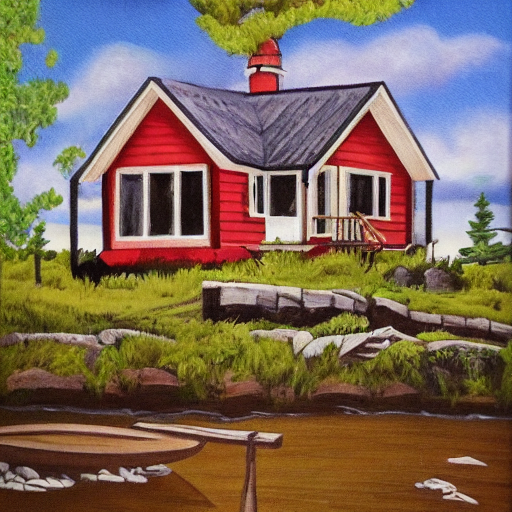

In [18]:
prompt = "cottage in northern Ontario in my style"
image = pipe(prompt, num_inference_steps=30).images[0]
image.save("my_lora_output.png")

from IPython.display import Image
Image("my_lora_output.png")

**Edit photo with model**